In [91]:
from utils import *
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
'''
Read the data and split it into train and test sets
'''
data = pd.read_csv('Data/data_with_lags_feature_selected.csv', index_col=0, parse_dates=True)

test_data = data.iloc[-int(len(data) * 0.1):]
train_data = data.iloc[:-int(len(data) * 0.1)]

In [28]:
'''
Class for RNN model
'''
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation, dropout):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity=activation)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

'''
Class for LSTM model
'''
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob, activation):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = getattr(nn, activation)() if activation != 'relu' else nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out
'''
Function for training a PyTorch model
'''
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

In [94]:
def evaluate_deep_models_ts_cv(train_data, test_data, param_grid, n_splits=5, model_name=None, plot_shap = True, directory = ''):
    '''
    
    :param train_data: Training data
    :param test_data: Test data
    :param param_grid: Hyperparameters grid to search
    :param n_splits: Number of slits for Cross validation
    :param model_name: Name of the model can be 'XGBoost', 'Random Forest', 'RNN', 'LSTM'
    :param plot_shap: Whether to plot SHAP values or not
    :param directory: Where to save the plots
    :return: The best model and the predictions on the test set
    '''
    # Extract target and features
    y_train = train_data.iloc[:, 0]
    X_train = train_data.iloc[:, 1:]
    y_test = test_data.iloc[:, 0]
    X_test = test_data.iloc[:, 1:]

    best_score = np.inf
    best_params = None

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns)
    y_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['Realized Volatility'])

    tscv = TimeSeriesSplit(n_splits=n_splits)

    param_combinations = list(ParameterGrid(param_grid))

    for params in param_combinations:
        cv_scores = []
        for train_index, val_index in tscv.split(X_scaled):
            X_tr, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
            y_tr, y_val = y_scaled.iloc[train_index], y_scaled.iloc[val_index]
            
            if model_name == 'XGBoost':
                model = xgb.XGBRegressor(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
            elif model_name == 'Random Forest':
                model = RandomForestRegressor(**params)
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)
            elif model_name == 'RNN':
                # Convert to PyTorch tensors and create DataLoader
                X_tr_tensor = torch.tensor(X_tr.values, dtype=torch.float32).unsqueeze(1)
                y_tr_tensor = torch.tensor(y_tr.values, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)
                y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
                train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
                train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
                                
                input_size = X_tr.shape[1]
                model = RNNModel(input_size, params['unit'], 1, params['activation'], params['dropout'])
                
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'adam' else optim.RMSprop(model.parameters(), lr=params['lr'])
                train_pytorch_model(model, train_loader, criterion, optimizer, params['epochs'])
                
                model.eval()
                with torch.no_grad():
                    y_pred_tensor = model(X_val_tensor)
                    y_pred = y_pred_tensor.numpy()
            elif model_name == 'LSTM':
                # Convert to PyTorch tensors and create DataLoader
                X_tr_tensor = torch.tensor(X_tr.values, dtype=torch.float32).unsqueeze(1)
                y_tr_tensor = torch.tensor(y_tr.values, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)
                y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
                train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
                train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
                input_size = X_tr.shape[1]
                model = LSTMModel(input_size, params['unit'], 1, params['num_layers'], params['dropout'], params['activation'])
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=params['lr']) if params['optimizer'] == 'adam' else optim.RMSprop(model.parameters(), lr=params['lr'])
                train_pytorch_model(model, train_loader, criterion, optimizer, params['epochs'])
                
                model.eval()
                with torch.no_grad():
                    y_pred_tensor = model(X_val_tensor)
                    y_pred = y_pred_tensor.numpy()

            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_pred = pd.DataFrame(y_pred, columns=['Realized Volatility'], index=y_val.index)

            MAPE = mean_absolute_percentage_error(scaler_y.inverse_transform(y_val), y_pred)
            cv_scores.append(MAPE)

        mean_cv_score = np.mean(cv_scores)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_params = params

        print(f"Results for params = {params}: MAPE = {mean_cv_score}")

    print(f"Best hyperparameters: {best_params} which gives MAPE: {best_score}")

    if model_name == 'XGBoost':
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(X_scaled, y_scaled)
    elif model_name == 'Random Forest':
        best_model = RandomForestRegressor(**best_params)
        best_model.fit(X_scaled, y_scaled)
    elif model_name == 'RNN':
        input_size = X_train.shape[1]
        best_model = RNNModel(input_size, best_params['unit'], 1, best_params['activation'], best_params['dropout'])
    elif model_name == 'LSTM':
        input_size = X_train.shape[1]
        best_model = LSTMModel(input_size, best_params['unit'], 1, best_params['num_layers'], best_params['dropout'], best_params['activation'])
    
    if model_name in ['RNN', 'LSTM']:
        X_scaled_tensor = torch.tensor(X_scaled.values, dtype=torch.float32).unsqueeze(1)
        y_scaled_tensor = torch.tensor(y_scaled.values, dtype=torch.float32)
        train_dataset = TensorDataset(X_scaled_tensor, y_scaled_tensor)
        train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=False, worker_init_fn=lambda _: set_seed(42))
        criterion = nn.MSELoss()
        optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr']) if best_params['optimizer'] == 'adam' else optim.RMSprop(best_model.parameters(), lr=best_params['lr'])
        train_pytorch_model(best_model, train_loader, criterion, optimizer, best_params['epochs'])

    X_test_scaled = scaler_X.transform(X_test)
    if model_name in ['XGBoost', 'Random Forest']:
        y_test_pred = best_model.predict(X_test_scaled)
    elif model_name in ['RNN', 'LSTM']:
        X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
        best_model.eval()
        with torch.no_grad():
            y_test_pred_tensor = best_model(X_test_scaled_tensor)
            y_test_pred = y_test_pred_tensor.numpy()
    
    y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_pred = pd.DataFrame(y_test_pred, columns=['Realized Volatility'], index=y_test.index)
    
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_test_pred)
    # Assuming calculate_cp, calculate_adjusted_r2, calculate_aic_bic functions are defined
    cp = calculate_cp(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])
    adjusted_r2 = calculate_adjusted_r2(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])
    aic, bic = calculate_aic_bic(y_test.values, y_test_pred.values, X_train.shape[1], X_train.shape[0])

    print(f"################################\n Test set results: MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R^2: {r2}, Adjusted R^2: {adjusted_r2}, C_p: {cp}, AIC: {aic}, BIC: {bic}, MAPE: {MAPE}")

    if model_name in ['LSTM', 'RNN'] and plot_shap:
        explainer = shap.DeepExplainer(best_model, X_scaled_tensor)
        shap_values = explainer.shap_values(X_test_scaled_tensor, check_additivity=False)

        shap_values = shap_values.reshape(shap_values.shape[0], shap_values.shape[2])

        X_test_scaled_tensor = X_test_scaled_tensor.reshape(X_test_scaled_tensor.shape[0], X_test_scaled_tensor.shape[2])
        X_test_scaled_tensor = np.array(X_test_scaled_tensor)

        shap.summary_plot(shap_values, X_test_scaled_tensor, feature_names=X_test.columns)
        plt.savefig(f'Outputs/Models/{directory}/SHAP_dot_summary_plot.png')
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_scaled_tensor, feature_names=X_test.columns, plot_type='bar', show=False)
        plt.title('SHAP Summary Plot (Bar)')
        plt.savefig(f'Outputs/Models/{directory}/SHAP_bar_summary_plot.png')

    return best_model, y_test_pred


In [95]:
'''
Function for setting the seed to make the results reproducible
'''
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

1 - LSTM model with multiple inputs

100%|██████████| 100/100 [00:16<00:00,  6.01it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.2914361480901688


100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.30357286200437655


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.31845297313197285


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.32741602765415656


100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3227620022607921


100%|██████████| 200/200 [00:39<00:00,  5.01it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3112796250369173


100%|██████████| 200/200 [00:46<00:00,  4.27it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3113182292272672


100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3201599103654725


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3028313500377267


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.315848708393333


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3115649777286059


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3253294670172041


100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.29566636052520084


100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.31781208165200375


100%|██████████| 200/200 [00:55<00:00,  3.59it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3033369448910679


100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.32171610031369885
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 50} which gives MAPE: 0.2914361480901688


100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


################################
 Test set results: MSE: 3.920836244209951e-06, RMSE: 0.001980110159614851, MAE: 0.0014923596088843043, R^2: 0.18848056070924413, Adjusted R^2: 0.18410448224692133, C_p: 0.00012753386362569788, AIC: -inf, BIC: -15006.986289252332, MAPE: 0.26238510241448687
torch.Size([1679, 1, 9])
torch.Size([186, 1, 9])
(186, 1, 9)


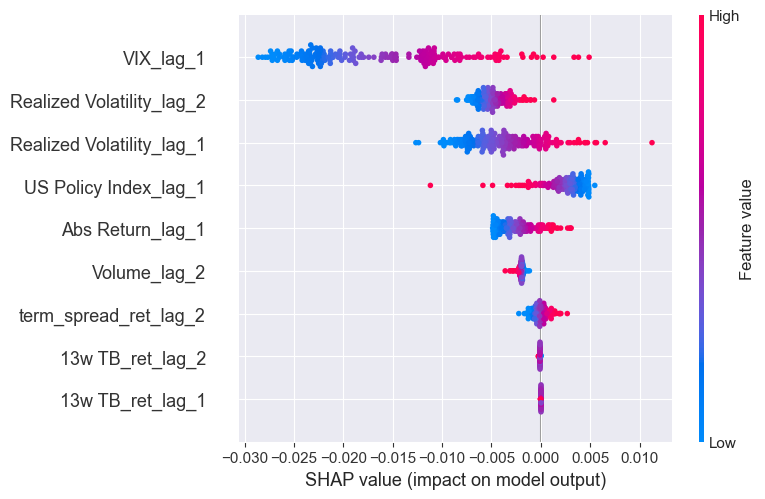

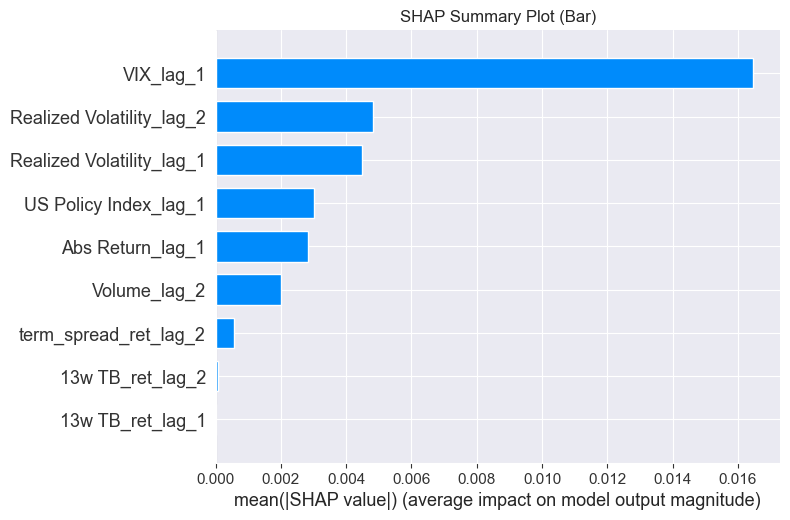

In [51]:
set_seed()

lstm_hyperparameters = {
    'unit': [50, 20],
    'num_layers': [1],
    'activation': ['relu'],
    'dropout': [0.1, 0.2],
    'optimizer': ['adam'],
    'epochs': [100, 200],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}

best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, lstm_hyperparameters, model_name='LSTM', n_splits=5, directory='LSTM_multiple_input')

In [52]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_LSTM = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_LSTM.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.007569
2023-04-06,0.005496,0.007701
2023-04-10,0.008563,0.007369
2023-04-11,0.003862,0.007928
2023-04-12,0.009014,0.007262


In [53]:
results_LSTM.to_csv('Outputs/Models/LSTM_multiple_input/LSTM_results.csv')

<Axes: >

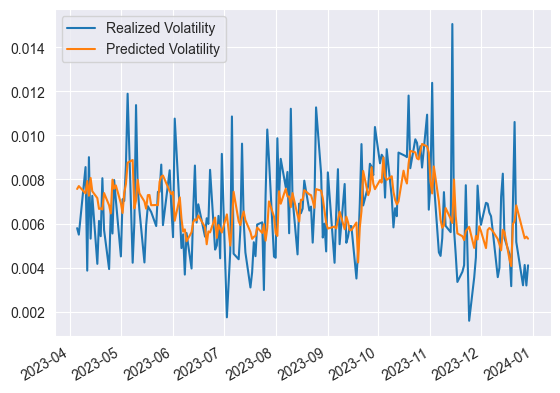

In [54]:
results_LSTM.plot()

2 - XGBoost model

In [58]:
set_seed()

xgboost_param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 10],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5]
}

best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, xgboost_param_grid, model_name='XGBoost')


Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}: MAPE = 0.35109445740914325
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}: MAPE = 0.3647799349308674
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}: MAPE = 0.3485552109094868
Results for params = {'colsample_bytree': 0.7, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500}: MAPE = 0.36458983940936784
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}: MAPE = 0.3975549485305083
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 500}: MAPE = 0.3975549485305083
Results for params = {'colsample_bytree': 0.7, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 100}: MAPE = 0.35717075863737485
Results for params = {'colsample_bytree': 0.7, 'max_dept

In [63]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_XGBoost = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_XGBoost.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.007676
2023-04-06,0.005496,0.006895
2023-04-10,0.008563,0.007516
2023-04-11,0.003862,0.008182
2023-04-12,0.009014,0.007565


In [64]:
results_XGBoost.to_csv('Outputs/Models/XGBoost/XGBoost_results.csv')

<Axes: >

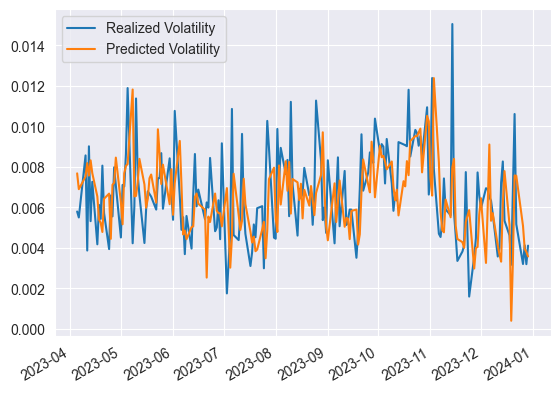

In [65]:
results_XGBoost.plot()

3 - Random Forest model

In [66]:
set_seed()
# Random Forest
random_forest_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt']
}
best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, random_forest_param_grid, model_name='Random Forest')

Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}: MAPE = 0.32070897975068685
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}: MAPE = 0.32002344839786023
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}: MAPE = 0.3222143599245223
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}: MAPE = 0.32255783922939585
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}: MAPE = 0.3147645057518127
Results for params = {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}: MAPE = 0.3172773390756473
Results for params = {'max_depth': 10, 'max_featu

In [67]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_RandomForest = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_RandomForest.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.007196
2023-04-06,0.005496,0.007361
2023-04-10,0.008563,0.006406
2023-04-11,0.003862,0.007849
2023-04-12,0.009014,0.006487


In [68]:
results_RandomForest.to_csv('Outputs/Models/Random Forest/RandomForest_results.csv')

<Axes: >

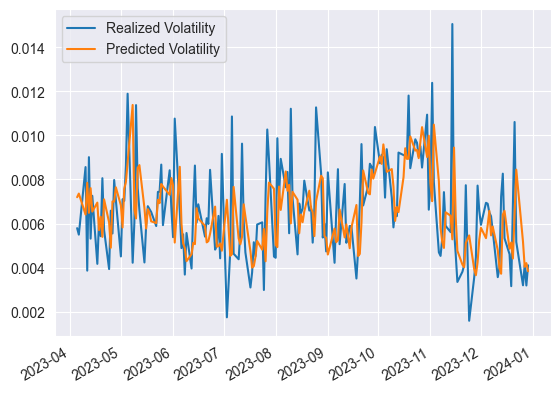

In [69]:
results_RandomForest.plot()

4 - RNN model

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.3267959370481045


100%|██████████| 100/100 [00:06<00:00, 14.50it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.5015896886373696


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.33460066109541564


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3293670972901285


100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.4238950302500931


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3688675139116363


100%|██████████| 200/200 [00:57<00:00,  3.50it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.33084357264333686


100%|██████████| 200/200 [00:18<00:00, 10.67it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3145051167286063


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.42434373537671916


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.4103797188516314


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.33685395050297573


100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.3621047364416449


100%|██████████| 200/200 [00:56<00:00,  3.56it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.39779921466709517


100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.2998014094983056


100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 50}: MAPE = 0.34400643614303217


100%|██████████| 200/200 [00:20<00:00,  9.96it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.001, 'optimizer': 'adam', 'unit': 20}: MAPE = 0.334819608068205
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'epochs': 200, 'lr': 0.01, 'optimizer': 'adam', 'unit': 20} which gives MAPE: 0.2998014094983056


100%|██████████| 200/200 [00:24<00:00,  8.16it/s]


################################
 Test set results: MSE: 7.636759688415561e-06, RMSE: 0.0027634687782595916, MAE: 0.0023448468785403943, R^2: -0.5806268240590637, Adjusted R^2: -0.5891502760761587, C_p: 0.00018283355550788736, AIC: -inf, BIC: -14402.220093428452, MAPE: 0.47425379977107085


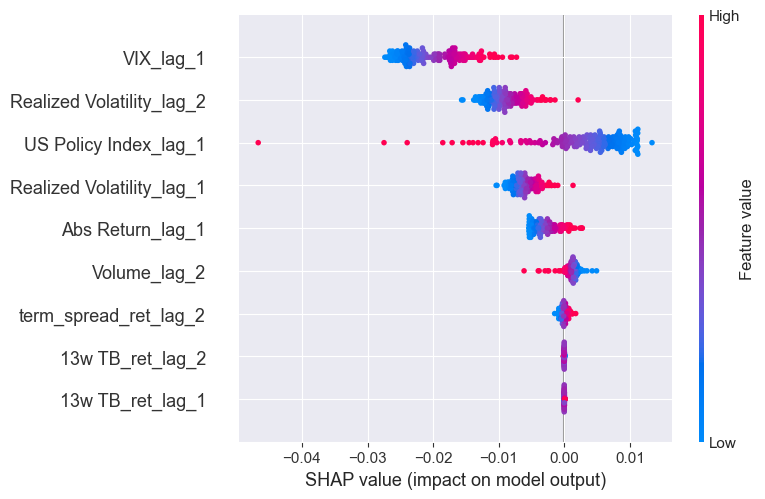

<Figure size 640x480 with 0 Axes>

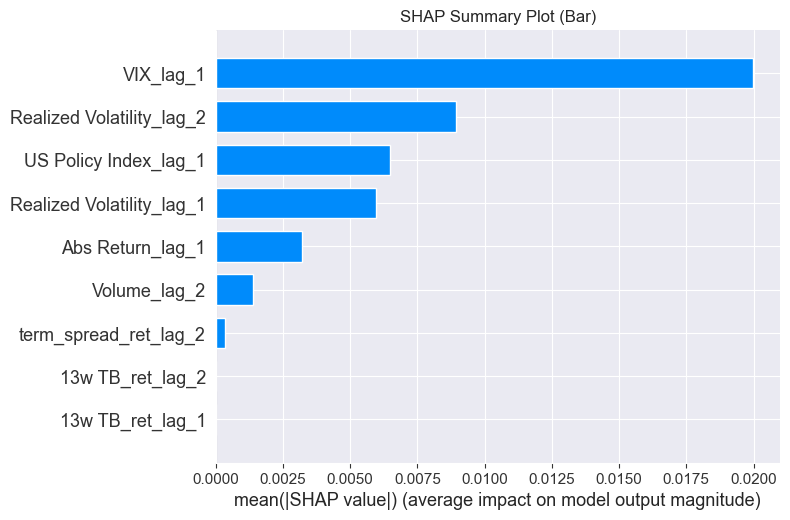

In [104]:
set_seed()

rnn_hyperparameters = {
    'unit': [50, 20],
    'activation': ['relu'],
    'dropout': [0.1, 0.2],
    'optimizer': ['adam'],
    'epochs': [100, 200],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}



best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data, test_data, rnn_hyperparameters, model_name='RNN', directory='RNN')


In [105]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_RNN = pd.concat([test_data[['Realized Volatility']], y_test_pred], axis = 1)
results_RNN.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.008214
2023-04-06,0.005496,0.008854
2023-04-10,0.008563,0.009262
2023-04-11,0.003862,0.008873
2023-04-12,0.009014,0.008418


In [106]:
results_RNN.to_csv('Outputs/Models/RNN/RNN_results.csv')

<Axes: >

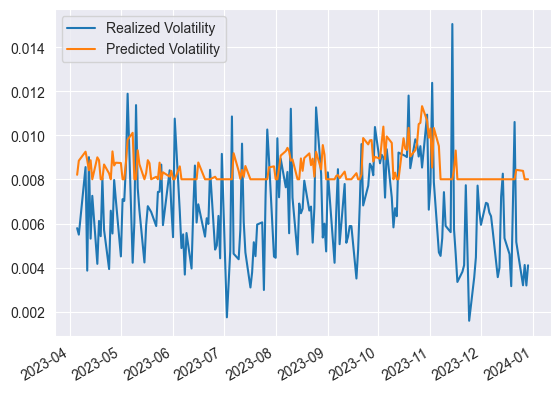

In [107]:
results_RNN.plot()

5 - LSTM model with single input

In [97]:
data2 = data[['Realized Volatility', 'Abs Return_lag_1']]

In [98]:
test_data2 = data2.iloc[-int(len(data) * 0.1):]
train_data2 = data2.iloc[:-int(len(data) * 0.1)]

In [100]:
lstm_hyperparameters = {
    'unit': [5, 10],
    'num_layers': [1],
    'activation': ['relu'],
    'dropout': [0.1],
    'optimizer': ['adam'],
    'epochs': [50, 100],
    'batch_size': [32],
    'lr': [0.01, 0.001]
}


best_model, y_test_pred = evaluate_deep_models_ts_cv(train_data2, test_data2, lstm_hyperparameters, model_name='LSTM', n_splits=5, plot_shap=False)

100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.5175198570087155


100%|██████████| 50/50 [00:08<00:00,  6.12it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.518483045493834


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.550433331069263


100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.4471515087944134


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.5090539600334396


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.01, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.5147064392402416


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 5}: MAPE = 0.48020135876994036


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


Results for params = {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 100, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10}: MAPE = 0.4519528869329822
Best hyperparameters: {'activation': 'relu', 'batch_size': 32, 'dropout': 0.1, 'epochs': 50, 'lr': 0.001, 'num_layers': 1, 'optimizer': 'adam', 'unit': 10} which gives MAPE: 0.4471515087944134


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]

################################
 Test set results: MSE: 1.3160980647936149e-05, RMSE: 0.0036278065891025874, MAE: 0.002949321381635446, R^2: -1.7240085968144614, Adjusted R^2: -1.7256329310999798, C_p: 0.0003074275000093391, AIC: -inf, BIC: -13573.10370222155, MAPE: 0.5618164150467678


In [101]:
y_test_pred.rename(columns = {'Realized Volatility': 'Predicted Volatility'}, inplace = True)
results_LSTM2 = pd.concat([test_data2[['Realized Volatility']], y_test_pred], axis = 1)
results_LSTM2.head()

,Realized Volatility,Predicted Volatility
2023-04-05,0.005790,0.008943
2023-04-06,0.005496,0.007427
2023-04-10,0.008563,0.007907
2023-04-11,0.003862,0.006669
2023-04-12,0.009014,0.006280


In [102]:
results_LSTM2.to_csv('Outputs/Models/LSTM_single_input/LSTM_single_input_results.csv')

<Axes: >

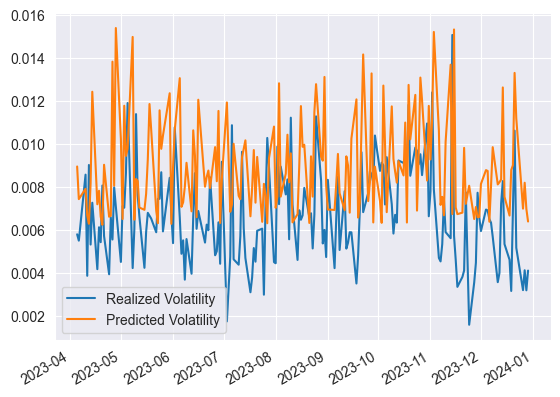

In [103]:
results_LSTM2.plot()